In [1]:
import pandas as pd
from API_Key import key, username, password
import psycopg2 as pg2
import json

In [2]:
conn = pg2.connect(database='TFT', user=username, password=password)
#c = conn.cursor()
df = pd.read_sql(sql=("select * from matches"),con=conn)

In [3]:
df.head()

,match,game_datetime,game_length,game_version,gold_left,last_round,level,placement,puuid,time_eliminated,total_damage,traits,units
0,NA1_3162393839,1569867523766,2263.492676,Version 9.19.290.8808 (Sep 25 2019/21:14:15) [...,3,1,7,1,a3U9LKm3Gs6LoKuJWYGfBw2RhM5UwvWuZi7_CYmEmf4hzT...,2241.134033,196,"[{""name"": ""Assassin"", ""num_units"": 1, ""tier_cu...","[{""items"": [], ""name"": ""Katarina"", ""tier"": 2},..."
1,NA1_3162393839,1569867523766,2263.492676,Version 9.19.290.8808 (Sep 25 2019/21:14:15) [...,1,1,7,4,ZqdoVA4Q1x9vfCGI6OG-J7HtF9DNGEjOD-G-uWiVDRIM-q...,2107.736084,122,"[{""name"": ""Blademaster"", ""num_units"": 2, ""tier...","[{""items"": [], ""name"": ""Vayne"", ""tier"": 3}, {""..."
2,NA1_3162393839,1569867523766,2263.492676,Version 9.19.290.8808 (Sep 25 2019/21:14:15) [...,18,1,8,5,CbzNpaTOk4ZIdMZb1321NsZFQTS8MUMKTpDtw8luqKCx0L...,1844.241333,87,"[{""name"": ""Assassin"", ""num_units"": 2, ""tier_cu...","[{""items"": [], ""name"": ""Khazix"", ""tier"": 2}, {..."
3,NA1_3162393839,1569867523766,2263.492676,Version 9.19.290.8808 (Sep 25 2019/21:14:15) [...,63,1,7,6,PbnixBPQ9SeDo5gsD2fctWdilCQPU6Quh_W06Iro_QIX4K...,1684.496582,42,"[{""name"": ""Assassin"", ""num_units"": 5, ""tier_cu...","[{""items"": [], ""name"": ""Zed"", ""tier"": 2}, {""it..."
4,NA1_3162393839,1569867523766,2263.492676,Version 9.19.290.8808 (Sep 25 2019/21:14:15) [...,1,1,8,8,AidJDUCfOyQcEE8t_vzO13z2iSaR7uiHU1dLR5kBitBAZz...,1548.534546,40,"[{""name"": ""Brawler"", ""num_units"": 1, ""tier_cur...","[{""items"": [], ""name"": ""Nidalee"", ""tier"": 2}, ..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140816 entries, 0 to 140815
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   match            140816 non-null  object 
 1   game_datetime    140816 non-null  int64  
 2   game_length      140816 non-null  float64
 3   game_version     140816 non-null  object 
 4   gold_left        140816 non-null  int64  
 5   last_round       140816 non-null  int64  
 6   level            140816 non-null  int64  
 7   placement        140816 non-null  int64  
 8   puuid            140816 non-null  object 
 9   time_eliminated  140816 non-null  float64
 10  total_damage     140816 non-null  int64  
 11  traits           140816 non-null  object 
 12  units            140816 non-null  object 
dtypes: float64(2), int64(6), object(5)
memory usage: 14.0+ MB


In [5]:
df['traits'] = df['traits'].apply(lambda x: json.loads(x))
df['units'] = df['units'].apply(lambda x: json.loads(x))


In [12]:
active_traits = []
for match in df.traits:
    active_traits.append([{trait['name']:trait['tier_current']} 
                          for trait in match 
                          if trait['tier_current'] >=1])

In [13]:
active_traits

[[{'Imperial': 2}, {'Knight': 3}],
 [{'Guardian': 1}, {'Knight': 1}, {'Noble': 2}],
 [{'Brawler': 1}, {'Ninja': 1}, {'Void': 2}],
 [{'Assassin': 1}, {'Ninja': 2}, {'Wild': 1}],
 [{'Sorcerer': 2}, {'Wild': 2}, {'Yordle': 1}],
 [{'Demon': 1}, {'Glacial': 1}, {'Knight': 1}, {'Phantom': 1}, {'Ranger': 2}],
 [{'Brawler': 2}, {'Robot': 1}, {'Void': 2}],
 [{'Demon': 1}, {'Elementalist': 1}, {'Ninja': 1}, {'Sorcerer': 2}],
 [{'Blademaster': 2}, {'Gunslinger': 1}, {'Hextech': 1}, {'Ninja': 1}],
 [{'Demon': 1}, {'Dragon': 1}, {'Shapeshifter': 2}, {'Wild': 1}],
 [{'Glacial': 1}, {'Guardian': 1}, {'Knight': 2}, {'Robot': 1}],
 [{'Guardian': 1}, {'Sorcerer': 1}],
 [{'Blademaster': 2},
  {'Exile': 1},
  {'Gunslinger': 2},
  {'Hextech': 1},
  {'Ninja': 1}],
 [{'Assassin': 2}],
 [{'Assassin': 1},
  {'Dragon': 1},
  {'Ninja': 1},
  {'Shapeshifter': 1},
  {'Wild': 2}],
 [{'Assassin': 1},
  {'Blademaster': 1},
  {'Demon': 1},
  {'Exile': 1},
  {'Imperial': 2},
  {'Ninja': 1}],
 [{'Demon': 3}, {'Ranger': 

In [9]:
df['active_traits'] = active_traits

<AxesSubplot:>

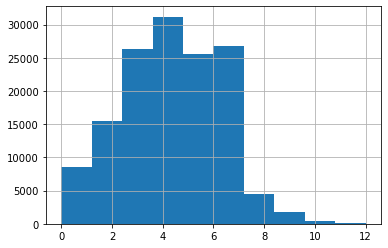

In [11]:
df.active_traits.apply(lambda x: len(x)).hist()

In [50]:
items = list()
carry = list()
for row in df['units']:
    for resources in row:
        if len(resources['items']) >=1:
            items.append(resources['items'])
            carry.append(resources['name'])

In [51]:
df['units'][0][0]

{'items': [], 'name': 'Katarina', 'tier': 2}

<AxesSubplot:>

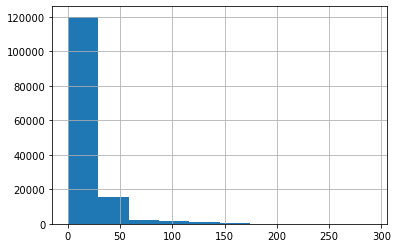

In [54]:
df.gold_left.hist()